**Yasaman Haghighi** and **Melina Francoise Chrysanthou** 

This aim of this course is to review the evolution of image processing tools from hand-crafted methods to deep learning algorithms. The semester is split into four labs :

* **Lab 1** : Introduction to Image Processing Using Hand-Crafted Features
* **Lab 2** : Object detection
* **Lab 3** : Object tracking
* **Lab 4** : Introduction to Deep Learning for image classification

Let's start with the first chapter of this course!

# Chapter 1 : Introduction to Image Processing Using Hand-Crafted Features 

(100 points)

In [1]:
import cv2 as cv
import numpy as np
import os
import math
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## 1.1 Introduction to Basic Image Processing Using OpenCV

(20 points)

In this section we'll start with the basic image processing in Python and show you how you can load an image, perform some basic processing on the image, changing the color spaces , using the threshold and color histogram.

**Goals:**

1. Read an image, access and modify pixel values
2. Set Region of Image (*ROI*)
3. Change color space
4. Understand the concepts of histogram and histogram equalization

Almost all the operations in this section are mainly related to Numpy rather than OpenCV. A good knowledge of Numpy is required to write better optimized code with OpenCV.

For more information check the [numpy](https://docs.scipy.org/doc/) and [opencv](https://www.docs.opencv.org/3.4.0/) documentations.

### 1.1.1 Accessing and Modifying pixel values

The code in the next section shows how one can load an image into the Jupyter notebook. 

In [2]:
# reading an image
img = cv.imread(os.path.join('..','data', 'lena.png'))
print('Image has dimensions: {}'.format(img.shape))
print('There is a total of {} elements'.format(img.size))

Image has dimensions: (512, 512, 3)
There is a total of 786432 elements


Elements of numpy array can be accessed through indexing, similar to Matlab. To do so, use the operator `[.]` where `.` indicates which dimensions you're accessing. OpenCV loads image with dimensions organised as follow: `rows, cols, channels`. More information about indexing in numpy can be found in the [doc](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

In [3]:
# accessing RED value
print('Red value at location {}x{} is {}'.format(10, 10, img[10, 10, 2]))
# modifying RED value
img[10,10,2] = 100
print('The new Red value at location {}x{} is {}'.format(10, 10, img.item(10,10,2)))


Red value at location 10x10 is 226
The new Red value at location 10x10 is 100


Image can be displayed using the provided function `display_image()` in file `utils.py`. It takes care of the conversion between OpenCV formatting and Matplotlib package for you.

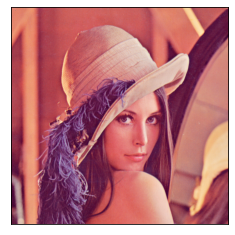

In [4]:
# Image can be displayed like thiss
display_image(img);

### 1.1.2 Image ROI

Sometimes, you will have to play with certain region of images. For eye detection in images, first perform face detection over the image until the face is found, then search within the face region for eyes. This approach improves accuracy (because eyes are always on faces :D ) and performance (because we search for a small area).

ROI is again obtained using Numpy indexing. Here I am selecting Lena's face.

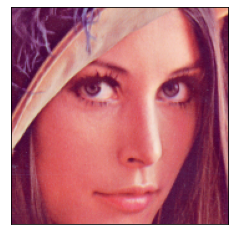

In [5]:
face = img[200:375, 200:375, :]
display_image(face);

### 1.1.3 Colorspace Conversion

In this tutorial, you will learn how to convert images from one colorspace to another, like BGR ↔ Gray, BGR ↔ YUV etc. In addition to that, we will create an application which extracts a colored object within an image. There are more than 150 color-space conversion methods available in OpenCV. But we will look into only two which are most widely used ones, BGR ↔ Gray and BGR ↔ YUV. 

In the next two cells, implements the conversion function going from BGR image to GRAY image and BGR to YUV image. There are built-in functions in OpenCV doing exactly that but for the moment we'll ask you to implement your **own** function in order to get the idea of what is happening under the hood.

In [6]:
def convert_rgb_to_grayscale(frame):
    """
    Convert a given rgb image into grayscale image
    :param frame: Color image to convert
    :return: Graysale image as numpy array
    """
    
    # CODE HERE
    image = np.dot(frame[..., :3], [0.2989, 0.5870, 0.1140])
    
    return image

In [7]:
def convert_rgb_to_yuv(frame):
    """
    Convert a given rgb image into hsv image
    :param frame: Color image to convert
    :return: YUV image as numpy array
    """
    
    # CODE HERE

    #Conversion matrix from rgb to yuv, transpose matrix is used to convert from yuv to rgb
    yuv_from_rgb = np.array([[0.114, 0.587,  0.299],
                             [0.436, -0.28886, -0.14713],
                             [-0.10001, -0.51499, 0.615]])
  
    # do conversion
    image = frame.dot(yuv_from_rgb.T) 
    # add the constants based on the conversion formula
    image += np.array([16, 128, 128]).reshape(1, 1, 3)
    # convert the image to uint8 format
    image = np.array(image, dtype = "uint8")
    return image

The following lines shows the conversion based on your implementation and the built-in function from OpenCV. If everything went well, the two should match.

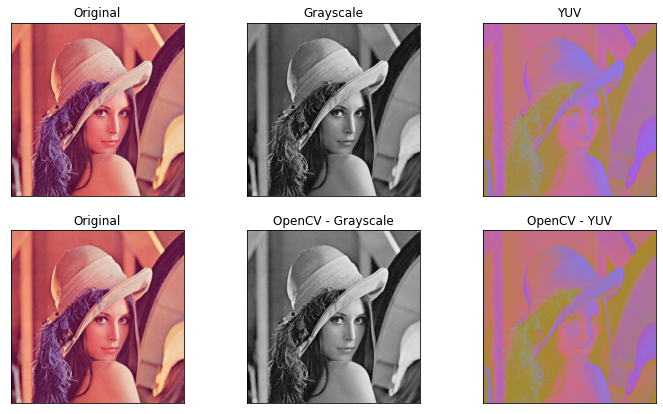

In [8]:
# Load image
img = cv.imread(os.path.join('..','data', 'lena.png'))
# convert to gray + hsv
img_gray = convert_rgb_to_grayscale(img)
img_yuv= convert_rgb_to_yuv(img)
gt_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gt_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
# Display
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
display_image(img, axes=ax[0][0])
ax[0][0].set_title('Original')
display_image(img_gray, axes=ax[0][1])
ax[0][1].set_title('Grayscale')
display_image(img_yuv, axes=ax[0][2])
ax[0][2].set_title('YUV')

display_image(img, axes=ax[1][0])
ax[1][0].set_title('Original')
display_image(gt_gray, axes=ax[1][1])
ax[1][1].set_title('OpenCV - Grayscale')
display_image(gt_yuv, axes=ax[1][2])
ax[1][2].set_title('OpenCV - YUV');
plt.show()

Now we know how to convert *BGR* image to a any color space, we can use this to extract a colored object. In *HSV*, it is more easier to represent a color than in *BGR* colorspace. In our application, we will try to extract a blue colored object. So here is the method:

1. Reading an input image
2. Convert from *BGR* to *HSV* color-space using bluit-in function from OpenCV
3. We threshold the *HSV* image for a range of blue color
4. Now extract the blue object alone, we can do whatever on that image we want

In [9]:
def threshold_bgr_image(frame, lower, upper):

    """
    Segment image.
        1. Convert image to HSV color space
        2. Binary masking using threshold values
        3. Fuse mask
    :param frame: BGR image to segment
    :param lower: Lower threshold value
    :param upper: Upper threshold value
    :return: Segmented image, binary mask
    """
    
    # CODE HERE  

    hsvImage = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    #create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
   
	  #find the colors within the specified boundaries and apply the mask
    mask = cv.inRange(hsvImage, lower, upper)
    #In order to have a weight background we fisrt subtract 255 from the Image
    #then add 255. In this case the pixels extracted by the mask will have their
    #original values and the other pixels will have white values
    res = cv.bitwise_and(frame-255, frame-255, mask = mask)
    res = res+255
    return res, mask

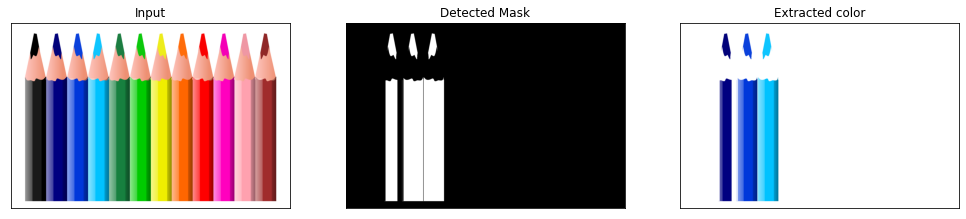

In [10]:
# 1. Read input
img = cv.imread(os.path.join('..','data', 'pencil.png'))

# 2. Define range of blue color in HSV
lower = np.asarray([90,120,120])
upper = np.asarray([130,255,255])
im, mask = threshold_bgr_image(img, lower, upper)

# 3. Display using subplots
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Input')
display_image(mask, axes=ax[1], cmap='gray')
ax[1].set_title('Detected Mask')
display_image(im, axes=ax[2])
ax[2].set_title('Extracted color');
plt.show()

In order to find *HSV* values, you can use the same function, `cv.cvtColor()`. Instead of passing an image, you just pass the *BGR* values you want. For example, to find the HSV value of RED, try following commands in Python terminal:

In [11]:
red = np.uint8([[[0, 0, 255 ]]])
hsv_red = cv.cvtColor(red, cv.COLOR_BGR2HSV)
print( 'HSV component {}'.format(hsv_red))

HSV component [[[  0 255 255]]]


Try to extract the two **GREEN** colored pencils.


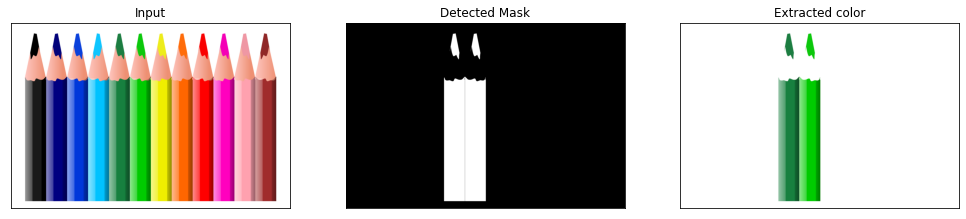

In [12]:
# Code here 

# Extract GREEN objects

# 1. Define range of green color in HSV
lower = np.asarray([36 ,0, 0])
upper = np.asarray([80 ,255, 255])
im, mask = threshold_bgr_image(img, lower, upper)

# 2. Display using subplots
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Input')
display_image(mask, axes=ax[1], cmap='gray')
ax[1].set_title('Detected Mask')
display_image(im, axes=ax[2])
ax[2].set_title('Extracted color');
plt.show()




Using the grayscale image, try to extract the **BLACK** pencil. What are the pros and cons of each method (colors *vs* grayscale)?


In [13]:
def threshold_gray_image(frame, lower, upper):

    """
    Segment image.
        1. Convert image to GrayScale color space
        2. Binary masking using threshold values
        3. Fuse mask
    :param frame: BGR image to segment
    :param lower: Lower threshold value
    :param upper: Upper threshold value
    :return: Segmented image, binary mask
    """
    
    # CODE HERE  

    grayImage = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    display_image(grayImage)

    #create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
   
    #find the colors within the specified boundaries and apply the mask
    mask = cv.inRange(grayImage, lower, upper)
    #In order to have a weight background we fisrt subtract 255 from the Image
    #then add 255. In this case the pixels extracted by the mask will have their
    #original values and the other pixels will have white values
    res = cv.bitwise_and(frame-255, frame-255, mask = mask)
    res = res+255
    return res, mask

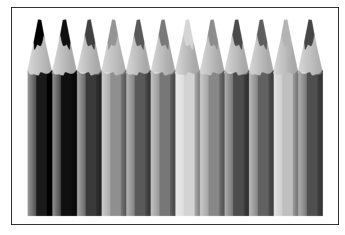

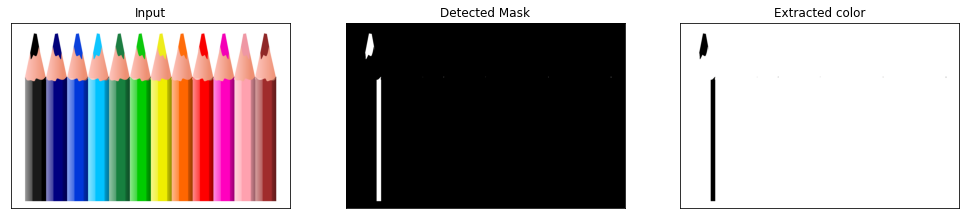

In [14]:
# Code here 
# Extract BLACK object with Greyscale

# 1. Define range of black color in greyscale
lower = np.asarray([0])
upper = np.asarray([8])
im, mask = threshold_gray_image(img, lower, upper)

# 2. Display using subplots
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Input')
display_image(mask, axes=ax[1], cmap='gray')
ax[1].set_title('Detected Mask')
display_image(im, axes=ax[2])
ax[2].set_title('Extracted color');
plt.show()



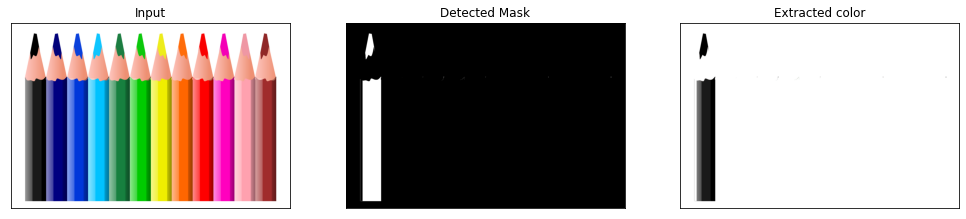

In [15]:
# Code here 
# Extract BLACK object with HSV

# 1. Define range of black color in HSV
lower = np.asarray([0,0,0])
upper = np.asarray([128,128,128])
im, mask = threshold_bgr_image(img, lower, upper)

# 2. Display using subplots
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Input')
display_image(mask, axes=ax[1], cmap='gray')
ax[1].set_title('Detected Mask')
display_image(im, axes=ax[2])
ax[2].set_title('Extracted color');
plt.show()



**YOUR ANSWER**

We can simply detect the black pencil while using HSV and the only difficulty is that we have to choose the threshold wisely. This is sometimes difficult as we have 3 degrees of freedom. On the other hand, selecting the threshold is much simpler for the greyscale images. Still, as you can see above, different colors look-alike in the grayscale image, and we can't detect the black pencil completely. If we increase the upper threshold, our function will detect the dark blue pen too. Even choosing several thresholds will not work here.

### 1.1.4 Image Histogram

So what is an histogram ? You can consider an histogram as a graph or plot, which gives you an overall idea about the intensity distribution of an image. It is a plot with pixel values (*ranging from 0 to 255 for 8-bits encoding, but it can be 16-bits, 24-bits, etc*) in X-axis and corresponding number of pixels in the image on Y-axis.

It is just another way of understanding the image. By looking at the histogram of an image, you get intuition about contrast, brightness, intensity distribution etc of that image. Almost all image processing tools today, provides features on histogram.

In the next cell, implement a function that compute the image histogram for all channels.

In [16]:
def compute_image_histogram(image):
    """
    Compute image color distribution for each channels of a given `image`
    :param image: Image to extract histograms for
    :return: List of histogram, one per channel.
    """
    hist = []
    
    # YOUR CODE HERE

    for channel in range(3):
      hist.append(cv.calcHist([image],      # image
                  [channel],           # channels
                   None,                # no mask
                   [256],      # size of histogram
                   [0, 256]  # channel values
                              ))
    
    
    return hist

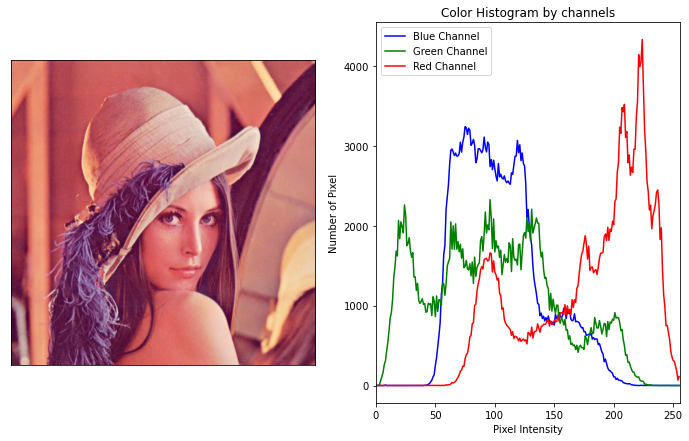

In [17]:
# Load image
img = cv.imread(os.path.join('..','data', 'lena.png'))

# Compute histogram for each channels
hists = compute_image_histogram(img)

# Plot 
color = ['b', 'g', 'r']
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
display_image(img, axes=ax[0])
for k, hist in enumerate(hists):
    ax[1].plot(hist, color=color[k])
ax[1].set_title('Color Histogram by channels')
ax[1].set_xlim([0, 256])
ax[1].set_xlabel('Pixel Intensity')
ax[1].set_ylabel('Number of Pixel')
plt.legend(['Blue Channel', 'Green Channel', 'Red Channel'])
plt.show()

You can see the image and its histogram. Left region of histogram shows the amount of darker pixels in image and right region shows the amount of brighter pixels. 

From the histogram, you can see for the *green* channel that pixels are mainly dark and midtones (*i.e. pixel values in mid-range, say around 127*). There is no bright green pixels in the image. On the other hand, *red* channel is mainly composed of pixels with high intensity (*i.e. distribution mainly located on the right hand side*).

#### 1.1.4.1 Histogram Equalization

Consider an image whose pixel values are confined to some specific range of values only. For instance, brighter image will have all pixels confined to high values. But a good image will have pixels from all regions of the image. So you need to stretch this histogram to either ends and that is what Histogram Equalization does. This normally improves the contrast of the image ([doc](https://en.wikipedia.org/wiki/Histogram_equalization)).

In the next section implement such contrast enhancement function (i.e. based on histogram equalization)

In [18]:
def csum(lst):
  # Cumulative sum function
    lst = iter(lst)
    cu_lst = [next(lst)]
    for i in lst:
        cu_lst.append(cu_lst[-1] + i)
    return np.array(cu_lst)
    
def contrast_enhancement(image):
    """
    Compute histogram and apply histogram equalization on a given image.
    :param image: Image to enhance contrast
    :return: tuple: enhanced image, input image histogram, transformed image histogram
    """
    
    hist = None
    hist_equ = None
    image_equ = None
    
    # YOUR CODE HERE
    
    ## input image histogram
    hist = cv.calcHist([image],[0],None,[256],[0,256])
    
    ## Enhanced image
    # Convert to np.array
    img = np.asarray(image)
    
    # Put pixels in a 1D array
    img1D = img.flatten()
    
    # cumulative sum   
    cu_sum = csum(hist)
    
    # Re-normalize csum values to be between the total number of gray levels (typically 256)
    nj = (cu_sum - cu_sum.min()) * 255
    N = cu_sum.max() - cu_sum.min()

    cu_sum = nj / N
    cu_sum = cu_sum.astype('uint8')
    
    # Get value from cumulative sum for every index in img1D
    image_equ = cu_sum[img1D]
    
    # Set back to original shape
    image_equ = np.reshape(image_equ, img.shape)
    
    ## Transformed image histogram
    hist_equ = cv.calcHist([image_equ],[0],None,[256],[0,256])
    
    return image_equ, hist, hist_equ

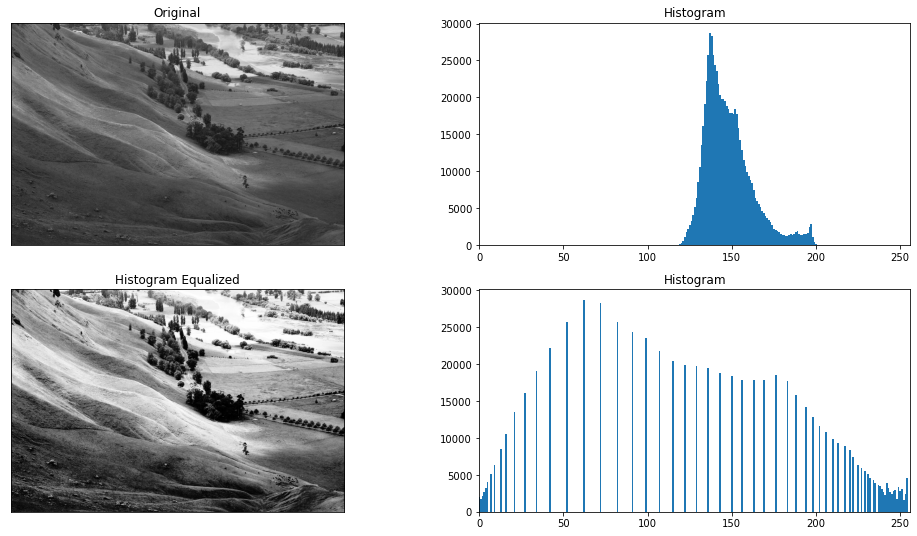

In [19]:
# Load image
img = cv.imread(os.path.join('..','data', 'hawkes_bay.jpg'), cv.IMREAD_GRAYSCALE)


# Enhance contrast with histogram equalization
img_equ, hist, hist_equ = contrast_enhancement(img)

# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
display_image(img, axes=ax[0][0])
ax[0][0].set_title('Original')
# Histogram original
ax[0][1].bar(np.arange(hist.shape[0]), hist.reshape(-1),  width=1)
ax[0][1].set_xlim([0, 256])
ax[0][1].set_title('Histogram')
# Histogram equalized
display_image(img_equ, axes=ax[1][0])
ax[1][0].set_title('Histogram Equalized')
ax[1][1].bar(np.arange(hist_equ.shape[0]), hist_equ.reshape(-1),  width=1)
ax[1][1].set_xlim([0, 256])
ax[1][1].set_title('Histogram');

- How has the contrast evolved after applying the transformation ? 
- How has the histogram changed ?

**QUESTION: In the next cell, comment on what you observe**.

**YOUR ANSWER**
The final image is brighter than the original one, and the contrast has increased. The histogram was skewed in the beginning, but it is more evenly spread after the transformation.

### 1.1.5 Image Thresholding

Here, the matter is straightforward. If pixel value is greater than a threshold value, it is assigned one value (*maybe white*), else it is assigned another value (*maybe black*). The function used is `cv.threshold(<image>, <thresh>, <maxVal>, <type>)`. First argument is the source image, which should be a grayscale image. Second argument is the threshold value which is used to classify the pixel values. Third argument is the maxVal which represents the value to be given if pixel value is more than (sometimes less than) the threshold value. OpenCV provides different styles of thresholding and it is decided by the fourth parameter of the function. Different types are:

1. `cv.THRESH_BINARY`
2. `cv.THRESH_BINARY_INV`
3. `cv.THRES_TRUNC`
4. `cv.THRESH_TOZERO`
5. `cv.THRESH_TOZERO_INV`

In the next cell, implement these thresholding operations within the function  `threshold_image`.

In [20]:
def threshold_image(image, thresh):
    """
    Apply different type of threshold to a given image + threshold value
    """
    
    img_bin = None
    img_bin_inv = None
    img_trunc = None
    img_tozero = None
    img_tozero_inv = None
    
    # YOUR CODE HERE
    _, img_bin = cv.threshold(image,thresh,255,cv.THRESH_BINARY)
    _, img_bin_inv = cv.threshold(image,thresh,255,cv.THRESH_BINARY_INV)
    _, img_trunc = cv.threshold(image,thresh,255,cv.THRESH_TRUNC)
    _, img_tozero = cv.threshold(image,thresh,255,cv.THRESH_TOZERO)
    _, img_tozero_inv = cv.threshold(image,thresh,255,cv.THRESH_TOZERO_INV)
     
    return img_bin, img_bin_inv, img_trunc, img_tozero, img_tozero_inv

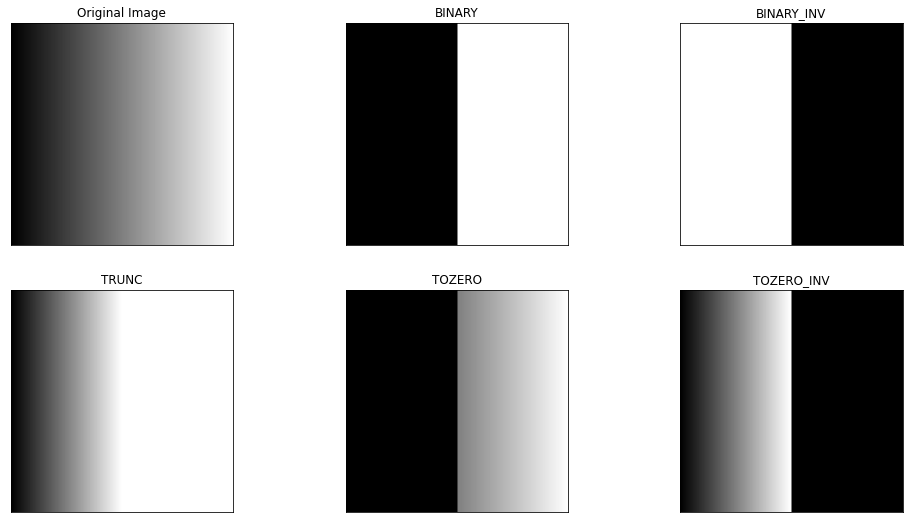

In [21]:
# Load image
img = cv.imread(os.path.join('..','data', 'grad.png'), cv.IMREAD_GRAYSCALE)

# Various threshold output
thresh1, thresh2, thresh3, thresh4, thresh5 = threshold_image(img, 127)


# Define how many figures will be drawn, save canvas + axes reference for later use
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
fig, ax = plt.subplots(2, 3, figsize=(17, 9))
# Draw each samples
for k in range(6):
    r = int(k / 3)
    c = k % 3
    # Show image
    display_image(images[k], axes=ax[r][c], cmap='gray')
    # Add title + remove tick
    ax[r][c].set_title(titles[k])
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([])

To plot multiple images, we have used `plt.subplots(...)` function. Please checkout Matplotlib docs for more details.

#### 1.1.5.1 Otsu Binarization

In global thresholding, we used an arbitrary value for threshold value. How can we know a value we selected is good or not? Answer is, trial and error method. But consider a bimodal image (In simple words, bimodal image is an image whose histogram has two peaks). For that image, we can approximately take a value in the middle of those peaks as threshold value. That is what Otsu binarization does. In simple words, it automatically calculates a threshold value from image histogram for a bimodal image. (For images which are not bimodal, binarization won’t be accurate.)

For this, our `cv.threshold()` function is used, but pass an extra flag, `cv.THRES_OTSU`. For threshold value, simply pass zero. Then the algorithm finds the optimal threshold value and returns you as the second output, retVal. If Otsu thresholding is not used, retVal is same as the threshold value you used.


Check out below example. Input image is a noisy image. In first case, a global thresholding value of 127 is applied. In second case, Otsu’s thresholding is applied directly. In third case, the image is filtered with a 5x5 gaussian kernel first to remove the noise, then applied Otsu thresholding. See how noise filtering improves the result.

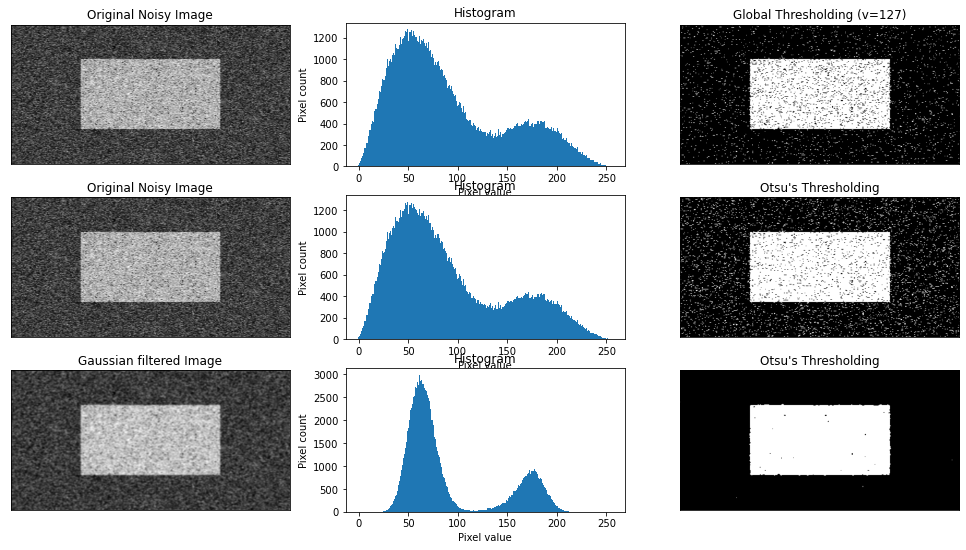

In [22]:
# Load image
img = cv.imread(os.path.join('..','data', 'noisy2.png'), cv.IMREAD_GRAYSCALE)

# global thresholding
ret1, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
# Otsu's thresholding
ret2, th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Compute histograms
# docs: https://docs.opencv.org/3.4.0/d6/dc7/group__imgproc__hist.html#ga4b2b5fd75503ff9e6844cc4dcdaed35d
hist_g = cv.calcHist([img], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
hist_f = cv.calcHist([blur], channels=[0], mask=None, histSize=[256], ranges=[0, 256])

# plot all the images and their histograms
images = [img, hist_g, th1,
          img, hist_g, th2,
          blur, hist_f, th3]
titles = ['Original Noisy Image', 'Histogram', 'Global Thresholding (v=127)',
          'Original Noisy Image', 'Histogram', "Otsu's Thresholding",
          'Gaussian filtered Image', 'Histogram', "Otsu's Thresholding"]

# Define how many figures will be drawn, save canvas + axes reference for later use
fig, ax = plt.subplots(3, 3, figsize=(17, 9))
# Draw each samples
for k in range(9):
    r = int(k / 3)
    c = k % 3
    if c != 1:
        # Show image
        display_image(images[k], axes=ax[r][c], cmap='gray')
        # Add title + remove tick
        ax[r][c].set_title(titles[k])
    else:
        # Draw histogram
        ax[r][c].bar(np.arange(images[k].shape[0]), images[k].reshape(-1), width=1)
        ax[r][c].set_title(titles[k])
        ax[r][c].set_xlabel('Pixel value')
        ax[r][c].set_ylabel('Pixel count')

## 1.2 Introduction to Local Binary Pattern (*LBP*)

(30 points)

Local Binary Pattern operator transforms an image, usually grayscale, into an image of integer labels describing small-scale appearance. These labels or their statistics, most commonly the histogram, are then used for further image analysis. 

The *LBP* operator acts at pixel level and compares each pixels with their neighbours. The surrounding pixels are thresholded by its center pixel value, multiplied by powers of two and then summed to obtain a label for the center pixel. Figure below shows how the neighboring pixels are defined. For instance with a neighbourhood of 8 pixels, a total of $2^8$ different labels can be obtained depending on the relative gray values of the center and the pixels in the neighborhood.

<img src="../data/lbp_sampling.png" alt="Drawing" style="width: 150px;"/>

Given a grayscale image $I\left(x, y \right)$ and $g_c$ being the gray level for an arbitrary pixel located at position $\left(x, y \right)$, then $g_c = I\left(x, y \right)$. Moreover assume $g_p$ being the gray value of a sampled point evenly spaced in the circular neighborhood of $P$ sampling points and a radius of $R$ around the point $\left(x, y \right)$, then:

$$
\begin{align}
g_p &= I\left(x_p, y_p \right), \quad p = 0, \dots, P - 1 \\
x_p &= x + R \cos \left(2 \pi p/P \right) \\
y_p &= y - R \sin \left(2 \pi p/P \right) \\
\end{align}
$$

As shown in the figure above, the sampling location might end up not corresponding to pixel position, therefore the intensity is estimated with interpolation. Most of the time we use `bilinear` interpolation [ref](https://en.wikipedia.org/wiki/Bilinear_interpolation). 

Finally the *LBP* operator can be defined as:

$$ LBP_{P,R}\left(x, y \right) = \sum_{p=0}^{P-1} s\left(g_p - g_c \right)2^{p} $$

where the thresholding function $s(.)$ is defined as:

$$
s\left(z\right) = \left\{ \begin{array}{ll} 1, & \quad z \geq 0 \\ 0, & \quad z < 0 \end{array} \right.
$$

Once the *LBP* operator is applied on the image, the feature vector is computed by accumulating the labels into a histogram with $2^P$ bins. The figure below shows an example of the different steps involved into the computation of *LBP* feature vector.

<img src="../data/lbp_example.png" alt="Drawing" style="width: 450px;"/>

More details can be found [here](https://link.springer.com/chapter/10.1007/978-0-85729-748-8_2).

Task to perform:
- Complete the implementation of the `bilinear` interpolation function
- Complete the implementation of the *LBP* operator
- Apply your operator on the `Lena` image using the code snippet provided

In [23]:
def bilinear_interpolation(image, x, y):

    """
    Interpolate pixel value at position (`x`, `y`) on a given image.
    
    :param image: Image from where to interpolation (np array)
    :param x: X coordinate of the location where to interpolate (float)
    :param y: Y coordinate of the location where to interpolate (float)
    :return: interpolated pixel value
    """
   
    pix_value = 0.0
    
    try: 
        # Four neighberhood pixels
        x1 = math.floor(x)
        x2 = x1 + 1
        
        y1 = math.floor(y)
        y2 = y1 + 1
        
        # Intensities of neighberhood pixels
        q11 = image[x1][y1]
        q12 = image[x1][y2]
        q21 = image[x2][y1]
        q22 = image[x2][y2]
        
            
        pix_value = (q11 * (x2 - x) * (y2 - y) +
                    q21 * (x - x1) * (y2 - y) +
                    q12 * (x2 - x) * (y - y1) +
                    q22 * (x - x1) * (y - y1)
                    )/((x2 - x1) * (y2 - y1))    
              
    except: 
        # Exception when neighbourhood values present at boundaries 
        pix_value = 0.0
 
    return pix_value

def local_binary_pattern_operator(image, P, R):
    """
    Ally Local Binary Pattern on a given image (Grayscale).
    
    :param image: Image to operate on
    :param P: Number of circularly symmetric neighbour set points (quantization of the angular space).
    :param R: Radius of circle (spatial resolution of the operator).
    """
    assert(image.ndim == 2)  
    
    val_ar = []
    
    height, width = image.shape 
    
    # Numpy array with same height and width of image 
    img_lbp = np.zeros((height, width),np.uint8) 

    # Going through the image to calculate LPB for all pixels
    for x in range(0, width):
        for y in range(0, height):
            val = 0
            for p in range (0,P-1):
                # Calculation of sampling location 
                x_p = x + R * math.cos(2 * math.pi * p/P)
                y_p = y - R * math.sin(2 * math.pi * p/P)
                
                pix_value = bilinear_interpolation(image,x_p,y_p)
                
                # Threshold pixel
                if pix_value >= image[x][y]:
                    val_ar.append(1)
                else:
                    val_ar.append(0)               
                
            # Convert binary values to decimal  
            
            for i in range(0,len(val_ar)): 
                    val += val_ar[i] * 2 **i

            img_lbp[x, y] = val 
            val_ar = []
            
    
    return img_lbp

In [24]:
# Load image
img = cv.imread(os.path.join('..','data', 'lena.png'), cv.IMREAD_GRAYSCALE)

# Apply LBP Operator
lbp_img = local_binary_pattern_operator(img, 8, 1)

# Compute normalized histogram
lbp_hist = cv.calcHist([lbp_img.astype(np.float32)], channels=[0], mask=None, histSize=[256], ranges=[0, 256])
lbp_hist /= lbp_hist.sum() + 1e-10

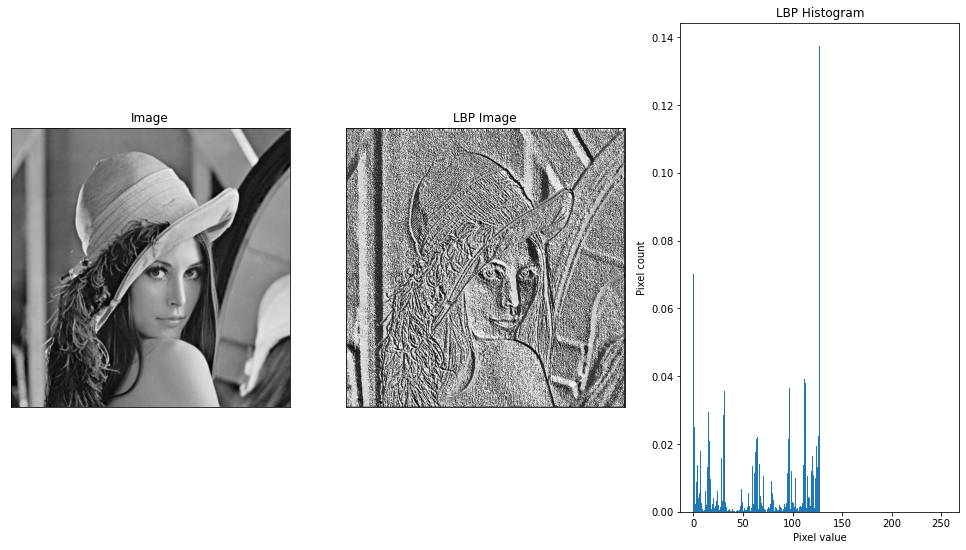

In [25]:
# Define how many figures will be drawn, save canvas + axes reference for later use
fig, ax = plt.subplots(1, 3, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Image')
# Show LBP image
display_image(lbp_img, axes=ax[1])

ax[1].set_title('LBP Image')
# Draw histogram
ax[2].bar(np.arange(lbp_hist.shape[0]), lbp_hist.reshape(-1), width=1)
ax[2].set_title('LBP Histogram')
ax[2].set_xlabel('Pixel value')
ax[2].set_ylabel('Pixel count');

## 1.3 Introduction to Histogram of Gradient (*HoG*)

(40 points)

### 1.3.1 Introduction

Histogram of Oriented Gradients (*HOGs*) are descriptors mainly used in computer vision and machine learning for object detection. HOG features were first introduced by Dalal and Triggs in their CVPR 2005 paper: "Histogram of Oriented Gradients for Human Detection" (<http://ieeexplore.ieee.org/document/1467360/>); which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination. Later on, we will use these descriptors for detection and tracking. 


In their work, Dalal and Triggs proposed HOG and a 5-stages descriptor to classify humans in static images.
The 5 stages included:

    1. Pre-processing and scaling.
    2. Computing gradients in both the x and y directions.
    3. Obtaining weighted votes in spatial cells (local histograms).
    4. Contrast normalizing overlapping spatial cells (Blocks).
    5. Collecting all Histograms of Oriented gradients to form the final feature vector.


In most real-world applications, HOG is used in conjunction with a __Linear SVM__ to perform object detection. HOG rapidly became one of the most used descriptors in image classification. The reason HOG is employed so heavily is because the local object appearance and shape can be characterized using the distribution of local intensity gradients. 

We’ll be discussing the steps necessary to combine both HOG and a Linear SVM into an object classifier later in this course. But for now, just understand that HOG is mainly used as a descriptor for object detection and that later these descriptors can be fed into a machine learning classifier.


### 1.3.2 Objectives of this module

HOG based classifiers are already implemented in several methods inside OpenCV. In this module, we will follow the basic steps to construct a feature vector based on HOG from scratch. Once the basic concepts are clear, at the end of this notebook, we will include the OpenCV build-in function used in real-world applications. The parameters of this function should be then clear for you to tune and play with for later applications.

*What are HOG descriptors used to describe?*

HOG descriptors are mainly used to describe the structural shape and appearance of an object in an image, making them excellent descriptors for object classification. In addition, since HOG captures local intensity gradients and edge directions, it also makes them good as texture descriptors.


### 1.3.3 Preprocessing

Typically, a feature descriptor converts an image of size $ width \times height \times 3 $(channels) to a feature vector array of length $n$. In the case of our implementation of the HOG feature descriptor, the input image will be of size 64 x 128 x 3 and the output feature vector of a length that will depend on various choices that we will make along the notebook. To further simplify the code below, we will also reduce the channel dimentionality to grayscale.

In [26]:
# loads base image
img = cv.imread(os.path.join('..','data', 'lena.png'))
print('Image has dimensions: {}'.format(img.shape))

# converts to grayscale
bgr_holder = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('Image has dimensions: {}'.format(bgr_holder.shape))

# resize the final image
bgr_img= cv2.resize(bgr_holder, (64, 128))
print('Image has dimensions: {}'.format(bgr_img.shape))

Image has dimensions: (512, 512, 3)
Image has dimensions: (512, 512)
Image has dimensions: (128, 64)


### 1.3.4 Gradient computation

https://en.wikipedia.org/wiki/Image_gradient

Gradient vectors (or “image gradients”) are one of the most fundamental concepts in computer vision; many vision algorithms involve computing gradient vectors for each pixel in an image. A gradient vector it’s simply a measure of the change in pixel values along the x-direction and the y-direction around each pixel. The magnitude is defined as:

$$
G(x,y) = \sqrt{(\Delta x^2 + \Delta y^2)}
$$

and the phase: 

$$
\theta(x,y) = atan(\frac{\Delta x}{\Delta y})
$$

Where: $\Delta x = f(x+1,y) - f(x-1,y)$ and $\Delta y = f(x,y+1) - f(x,y-1)$, are simply the directional change from one pixel to the other.

The simplest implementation of the aforementioned operators computes each value by using a mask operator: $-1|0|1$ over the pixel position in each direction. However the Sobel operator is usually employed as it is more robust to intensity changes: https://en.wikipedia.org/wiki/Sobel_operator 


In [27]:
# OpenCV includes a build-in function for directional derivatives. 
# Calculate gradients gx, gy
gx = cv.Sobel(bgr_img, cv2.CV_64F, 1, 0, ksize=1) # 1,0 means in the (1,0) direction
gy = cv.Sobel(bgr_img, cv2.CV_64F, 0, 1, ksize=1)  # 0,1 means in the (1,0) direction

## Rember to use the comand: 
## help(cv.Sobel) 
## in case of troubles.

The Sobel [function](https://docs.opencv.org/3.2.0/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d) is really useful for many applications where we would like to compute the local intensity changes, for example for edge detection and texture synthesis. 

The resulting objects from (gx, gy) contains the "derivative map" in the selected direction (1,0 for x; 0,1 for y)

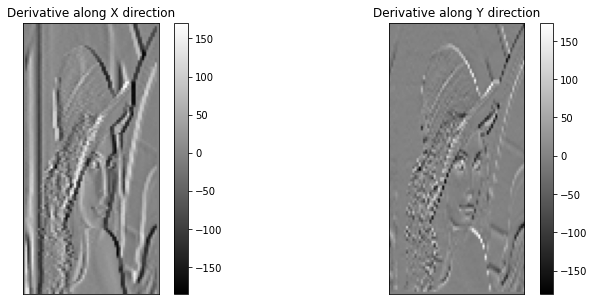

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
obj = display_image(gx, axes=ax[0])
ax[0].set_title('Derivative along X direction')
fig.colorbar(obj, orientation ='vertical', ax=ax[0])
obj = display_image(gy, axes=ax[1])
ax[1].set_title('Derivative along Y direction')
fig.colorbar(obj, orientation ='vertical', ax=ax[1])
plt.show()

In [29]:
# Let's zoom up a litte bit to see the intensity changes.
#Region of interest
gx_roi = gx[50:100, 30:50]
gy_roi = gy[50:100, 30:50] #face region.

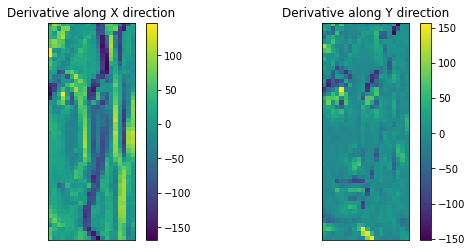

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
obj = display_image(gx_roi, axes=ax[0], cmap='viridis')
ax[0].set_title('Derivative along X direction')
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(obj, orientation ='vertical', ax=ax[0])
obj = display_image(gy_roi, axes=ax[1], cmap='viridis')
ax[1].set_title('Derivative along Y direction')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(obj, orientation ='vertical', ax=ax[1])
plt.show()

**QUESTION: Does the images above make sense?  Please provide some good captions to what it's being displayed.**

**YOUR ANSWER**
The derivative of a function tells you the rate of change, and an edge constitutes a high rate of change. A gradient image in the x direction measuring horizontal change in intensity and a gradient image in the y direction measuring vertical change in intensity. In the df/dx image, the vertical boundary between her face and the background is more apparent, or similarly the vertical boundary of her nose and eyes and lips. The df/dy image, on the other hand, accentuates horizontal edges like the edge of her eyes, and her eyebrows.

**QUESTION: What's the meaning of the brightest or darkest pixels for each directions?**

**YOUR ANSWER**
The brightest or darkest pixels for each directions have a large gradient.
A transition from light to dark pixels is shown by bright pixels, while a dark to light transition is shown by dark pixels.

The images above shows the partial derivatives in a given direction. We can use them to compute the magnitude and phase as in the above formulas.

We can actually compute the magnitude using the cartToPolar function.


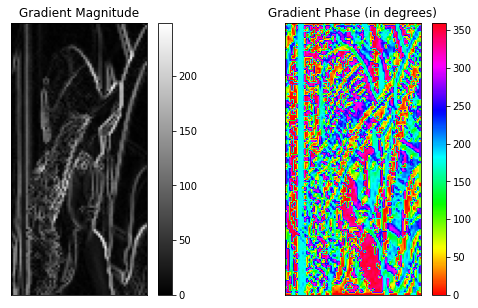

In [31]:
# Magnitude computation -> Gradient = sqrt(gx*gx + gy*gy)

# OpenCv provides a build-in function to compute the magnitude matrix (image).
G = cv.magnitude(gx,gy)

# And the direction ( in degrees ) 
_,phase = cv.cartToPolar(gx, gy, angleInDegrees=True,)

# We can actually compute the magnitude using the cartToPolar function. Try it! 
# ---------------------------------



# YOUR CODE HERE
mag, _ = cv.cartToPolar(gx, gy)

if (G-mag).any :
  print("We can actually compute the magnitude using the cartToPolar function.")

# ---------------------------------
# Plots of the magnitude and the phase:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

#The magnitude is shown in gray scale.
obj = display_image(G, axes=ax[0])
ax[0].set_title('Gradient Magnitude')
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(obj, orientation ='vertical', ax=ax[0])

# The phase is shown using a color map. 
# Is worth notice that there are many homogeneous regions.
obj = display_image(phase, axes=ax[1], cmap='hsv')
ax[1].set_title('Gradient Phase (in degrees)')
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(obj, orientation ='vertical', ax=ax[1])
plt.show()

From the image above, we can see than the phase is computed from 0 to 360 degrees. While this is conceptually correct,two pixels with very similar angular values towards the X-axis (let's say 0.1 radians and 6.2 radians) will be considered very different by a naive classifier. We can correct this behaviour by wrapping the phase from 0 to $\pi$ (0 to 180 degrees). At the end of the notebook, you will be asked to correct the range of the phase.

From the phase image above we can see that there are a a big number of pixels in red (values very close to zero). 

**QUESTION: Does this mean that the gradient is really well oriented in those regions, or can it be an different effect?**
*Hint: consider the values of gx and gy in those regions.*


**YOUR ANSWER**
As: $$
\theta(x,y) = atan(\frac{\Delta y}{\Delta x})
$$
$$ \theta(x,y) = 0 $$ shows that we have no changes in y direction.

### 1.3.5 Computation of the Histograms of the Phase for Local Cells

As the name accurately suggest, the key step is to compute the histograms of Oriented Gradients (i.e. the phase). Those histograms however are computed locally for "cells" of a given size. By a cell we refer to a rectangular region of interest sliding across the image domain. The size and shape of the cell will affect the performance of HOG as a feature vector. Many variants have been proposed regarding the use of different cells sizes and multiple resolutions.


We will focus in this exploration in fixed $8 px\times 8px$ cells, since they fit the not-planned-at-all size of our input ( $128\times 64$). 

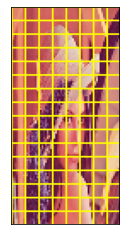

In [32]:
# This parameter is usually constant and it's never changed true the procedure.
CELL_SIZE = 8;

# Example of a cell drawn in yellow
img_canvas = cv2.resize(img, (64, 128)) # temporal image.

#useful for loop, can be done without it though.
for stride_x in range(1,img.shape[0]-1):
    for stride_y in range(1,img.shape[1]-1):
        cv2.rectangle(img_canvas, (0 + (stride_x-1)*CELL_SIZE, 0 + (stride_y-1)*CELL_SIZE), (0 + stride_x*CELL_SIZE, 0 + stride_y*CELL_SIZE), (0, 255, 255))

display_image(img_canvas)
plt.show()

Text(0.5, 1.0, 'Orientation distribution')

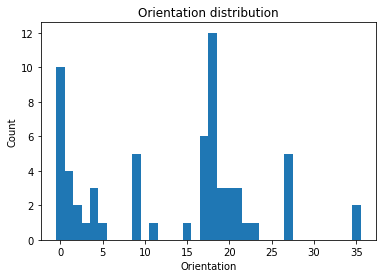

In [33]:
# Histogram of the Phase for the very first cell
num_of_bins = 36 # this is an important parameter
# Compute histogram
hist = cv.calcHist([phase[0:8, 0:8].astype(np.float32)], channels=[0], mask=None, histSize=[num_of_bins], ranges=[0,360])
# Plot
plt.bar(np.arange(hist.shape[0]), hist.reshape(-1), width=1)
plt.xlabel('Orientation')
plt.ylabel('Count')
plt.title('Orientation distribution')

Image above shows the cell subdivisions of the (colour) image for cells of size $8\times 8$. We then computed the histogram of gradient directions for each one of them. This will give us a consensus of the magnitude direction for a given fixed area. In order to compute the histogram, the number of bins considered will affect the performance and quality of the descriptor. In the original paper, Dalal and Triggs found that a 9 orientations histogram (from 0 to 180 degrees) performed well for human detection. 

In [34]:
# We can compute the histogram of each cell by following the same procedure that 
# we used for drawing the cells:


def computeCellHistograms(phase_img, cell_size):
    """
    Compute histogram for each cells and concatenate them.
    
    :param phase_img: 1 channel image with the gradient direction.
    :params cell_size: custion cell size (8px) 
    :return: histogram
    """
    
    # Resulting histogram vector
    concatenated_histograms =[];
    
    # Number of cells in each direction.
    x_num_blocks = int(phase_img.shape[0]/cell_size);
    y_num_blocks = int(phase_img.shape[1]/cell_size);

    
    for stride_x in range(1,int(x_num_blocks)):
        x_range = range((stride_x-1)*cell_size, stride_x*cell_size);
        for stride_y in range(1,y_num_blocks):
            y_range = range((stride_y-1)*cell_size, stride_y*cell_size);
            hist_ = cv.calcHist([phase_img[x_range,y_range].astype(np.float32)], 
                                channels=[0], mask=None, histSize=[36], ranges=[0,360])
            # Concatenate features
            concatenated_histograms.append(hist_)
    print("Cell size is:{}".format(np.shape([phase_img[x_range,y_range].astype(np.float32)])))        
    return concatenated_histograms
            
# Compute histogram
histograms = computeCellHistograms(phase, 8)
print("Histogram size is:{}".format(np.shape(histograms)))

Cell size is:(1, 8)
Histogram size is:(105, 36, 1)


**QUESTION: What's the size of the concatenated histogram, does it makes sense, should we do something?**

**YOUR ANSWER**
As we can see above the histogram size is (105, 36, 1) that is not correct and its because the range(1,int(x_num_blocks)) is from 1 to int(x_num_blocks)-1 . The second problem is that phase_img[x_range,y_range] will select only 8 elements instead of a 8*8 cell. We could change the code like below:

In [35]:
# Your code

In [36]:
def computeCellHistograms(phase_img, cell_size):
    """
    Compute histogram for each cells and concatenate them.
    
    :param phase_img: 1 channel image with the gradient direction.
    :params cell_size: custion cell size (8px) 
    :return: histogram
    """
    
    # Resulting histogram vector
    concatenated_histograms =[];
    
    # Number of cells in each direction.
    x_num_blocks = int(phase_img.shape[0]/cell_size);
    y_num_blocks = int(phase_img.shape[1]/cell_size);

    
    for stride_x in range(1,int(x_num_blocks)+1):
        x_range = range((stride_x-1)*cell_size, stride_x*cell_size);
        for stride_y in range(1,y_num_blocks+1):
            y_range = range((stride_y-1)*cell_size, stride_y*cell_size);
            hist_ = cv.calcHist(phase_img[(stride_x-1)*cell_size: stride_x*cell_size,
                                           (stride_y-1)*cell_size: stride_y*cell_size].astype(np.float32), 
                                channels=[0], mask=None, histSize=[36], ranges=[0,360])
            # Concatenate features
            concatenated_histograms.append(hist_)
    print("Cell size is:{}".format(np.shape(phase_img[(stride_x-1)*cell_size: stride_x*cell_size,
                                           (stride_y-1)*cell_size: stride_y*cell_size].astype(np.float32))))        
    return concatenated_histograms
            
# Compute histogram
histograms = computeCellHistograms(phase, 8)
print("Histogram size is:{}".format(np.shape(histograms)))

Cell size is:(8, 8)
Histogram size is:(128, 36, 1)


In [37]:
# We can see that now the size is correct

The code above computes the histogram of each cell and concatenate it into a single array. However, the code above assumes that each direction has the same *importance* and contributes equally to the histogram. 

In the original paper, it was proposed to __weigth__ the angle histogram, for instance, using the magnitud or the normalized magnitude computed before. The effect is depicted bellow:

<img src="https://gurus.pyimagesearch.com/wp-content/uploads/2015/03/hog_histogram_animation.gif">
<em> Image taken from: https://gurus.pyimagesearch.com </em>


For each of the gradient blocks, the histogram bins are weighted by the gradient magnitude. The effect of normalizing such weights will directly affect the contribution of larger edges vs smaller features. 

**CODING EXERCISE, modify the function *computeCellHistogram* above, the new function should use the gradient image G to weight the computed histogram.**

HINT: The easiest way would be to write your own custom histogram function that takes a second image with the weights.

Avoid using pre-defined functions.



In [38]:
def weighted_hist(phase, mag, width, height, bins, degree):
    """
    Compute weighted histogram for each cells. The weighted hist will be calculated
    based on the documents provided in the third link.
    
    :param phase: 1 channel image with the gradient direction.
    :param mag: 1 channel image with the gradient magnitude.
    :params width: custion cell size (8px)
    :params height: custion cell size (8px) 
    :param bins: histogram bins
    :param degree: choose if degree is between 0-360 or 0-180
    :return: histogram

    """
    # distance between bins
    step = bins[1] - bins[0] 
    hist = np.zeros(len(bins)) 
    # for each cell:
    for x in range(width): 
        for y in range(height): 
            # if the phase is betweeen the last bin and the first bin
            if phase[x, y] >= bins[-1]: 
                orientation_start = bins[-1] 
                orientation_end = degree 
                # assign weights based on the distance of the selected phase and the bins
                alpha = (phase[x, y] - orientation_start)/(orientation_end - orientation_start) 
                hist[-1] += (1 - alpha)*mag[x, y] 
                hist[0] += alpha*mag[x, y] 
            # else for other bins
            else: 
                # find the bins that the selected phase is between them
                index = int(phase[x, y]//step) 
                orientation_start = bins[index] 
                orientation_end = bins[index + 1] 
                # assign weights based on the distance of the selected phase and the bins
                alpha = (phase[x, y] - orientation_start)/(orientation_end - orientation_start) 
                hist[index] += (1 - alpha)*mag[x, y] 
                hist[index+1] += alpha*mag[x, y] 
    return hist.tolist()


In [39]:
def computeCellHistogramsWeighted(phase_img, mag_img, cell_size, bin_max, bin_num):
    """
    Compute weighted histogram for each cells and concatenate them.
    
    :param phase_img: 1 channel image with the gradient direction.
    :param mag_img: 1 channel image with the gradient magnitude.
    :params cell_size: custion cell size (8px) 
    :param bin_max: could be either 360 or 180 based on the phase wrapping
    :param bin_num: number of bins
    :return: histogram
    """
    weigthed_and_concatenated_histograms = []
    
    
    # CODE HERE

    # calculate the histogram bins
    bin_min = 0
    bin_step = (bin_max - bin_min)//bin_num
    bins = np.arange(bin_min, bin_max, bin_step)


    # Number of cells in each direction.
    x_num_blocks = int(phase_img.shape[0]/cell_size);
    y_num_blocks = int(phase_img.shape[1]/cell_size);
    
    for stride_x in range(1,int(x_num_blocks)+1):
        for stride_y in range(1,y_num_blocks+1):
            # use the function above to calculate hists
            hist_ = weighted_hist(phase_img[(stride_x-1)*cell_size: stride_x*cell_size,
                                           (stride_y-1)*cell_size: stride_y*cell_size].astype(np.float32), 
                                  mag_img[(stride_x-1)*cell_size: stride_x*cell_size,
                                           (stride_y-1)*cell_size: stride_y*cell_size].astype(np.float32)
                                  , cell_size, cell_size, bins, bin_max)
            # Concatenate features
            weigthed_and_concatenated_histograms.append(hist_)


    return weigthed_and_concatenated_histograms
 

# Compute weighted histogram
weighted_histograms = computeCellHistogramsWeighted(phase, mag, 8, 360, 36)
print("Histogram size is:{}".format(np.shape(weighted_histograms)))

Histogram size is:(128, 36)


### 1.3.6 Block normalization

In the previous steps, we created a histogram based on the gradient of the image. Gradients of an image are sensitive to overall lighting. If you make the image darker by dividing all pixel values by 2 for example, the gradient magnitude will change by half, and therefore the histogram values will change by half. Ideally, we want our descriptor to be independent of lighting variations. In other words, we would like to “normalize” the histogram so they are not affected by lighting variations.

The last step of the HOG algorithm takes overlapping blocks of cells to compute the final feature vector. Rather than normalizing each histogram individually, the cells are first grouped into __blocks__ and normalized based on all the histograms in the block. These procedure makes the feature detector less sensitive to intensity changes.


<img src = "https://gurus.pyimagesearch.com/wp-content/uploads/2015/03/hog_contrast_normalization.gif">
<em> Image taken from: https://gurus.pyimagesearch.com </em>

Image above shows each block as a group of 4 cells. This is refered as a block of size 2 by 2 cells. Contrast normalization is performed over multiple overlapping cells. Using this scheme, each cell is represented in the histogram multiple times; however, this redundancy actually improves accuracy. Finally, after all blocks are normalized, we take the resulting histograms, concatenate them, and treat them as our final feature vector.

**CODING EXERCISE**

In [40]:

# Final function to compute the final feature vector.
# Each block should be of size 4, i.e. 2 x 2 cells.
# The normalization should be done via the L2 or L1.
def BlockNormalizationAndFeatureConcatenation(histograms, x_size, y_size, bin_num):
    """
    normalize blocks.
    
    :param histograms: histograms calculated for each cell
    :param mag_img: 1 channel image with the gradient magnitude.
    :params x_size: number of blocks in x axis.
    :param y_size: number of blocks in y axis.
    :param bin_num: number of bins
    :return: feature vector
    """
    #CODE HERE
    histograms = np.reshape(histograms,(y_size, x_size, bin_num))
    
    max_h = y_size
    max_w = x_size
    block = [2,2]
    
    # choose the first block
    max_h = int((max_h-block[0])+1)
    max_w = int((max_w-block[1])+1)
    feature_vector = []
    w = 0
    h = 0
    i = 0
    j = 0

    while i<max_h:
      w = 0
      j = 0

      while j<max_w:
        # normalize it using L2 norm
        for_norm = histograms[h:h+block[0],w:w+block[1]]
        mag = np.linalg.norm(for_norm)+0.00001 # a constant is added to avoid division by 0
        arr_list = (for_norm/mag).flatten().tolist()
        # add the results to feature vectore
        feature_vector += arr_list
        # move to the next cell
        j += 1
        w += 1

      i += 1
      h += 1
    
    return feature_vector

In [41]:
vec = BlockNormalizationAndFeatureConcatenation(weighted_histograms, 8, 16, 36)
print("The final descriptor size is:{}".format(len(vec)))

The final descriptor size is:15120


### 1.3.7 Final Descriptor Size (CODING EXERCISE)

The 64 x 128 pixels detection window will be divided into 7 blocks across and 15 blocks vertically, for a total of 105 blocks. Each block contains 4 cells with a 9-bins histogram for each cell, for a total of 36 values per block. This brings the final vector size to 7 blocks across $\times$ 15 blocks vertically $\times$ 4 cells per block $\times$ 9-bins per histogram = 3,780 values.


Confirm that the dimentions above coincide (spoiler alert: they don't) with these ones. If not, correct the proper lines of code to make the coincide.

As we are using 36 bins the sizes are not the same and is 4 times bigger. We will change the number of bins and will wrap the phase to be between 0 and 180 below.

In [42]:
# Based on https://learnopencv.com/histogram-of-oriented-gradients/ the phase should be mapped like below
phase_new = phase.copy()
idx = np.where(phase_new > 180)
phase_new[idx] = phase_new[idx]-180

In [43]:
weighted_histograms_180 = computeCellHistogramsWeighted(phase_new, mag, 8, 180, 9)
vec_180 = BlockNormalizationAndFeatureConcatenation(weighted_histograms_180, 16, 8, 9)
print("The final descriptor size is:{}".format(len(vec_180)))

The final descriptor size is:3780


We can observe that the size is correct after the changes

### 1.3.8 Feature Vector Visualization

The final descriptor is then a 1-dimentional array with the concatenation of the blocks normalized histograms. However, this shouldn't prevent us from having an intuitive visualization of the computed features. 

**CODING EXERCISE: As last exercise, you need to display the feature vector over the image space (or any clever way). References bellow and the whole internet may have some good ideas about this. You are free to use any build-in function you may find.***

Based on the provided links, there is no way to visualize the HoGs. The skimage library that is vastly used, will plot the HoGs before normalization. We used the source code of this library and plot our HoGs. We then plot the Image calculated by the library itself. We can observe that the results are similar.

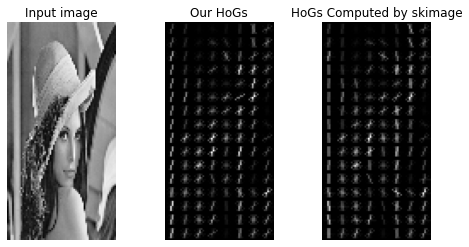

In [44]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure, draw
#cell size
c_row = 8 
c_col = 8

orientations = 9 # number of bins
s_row, s_col = bgr_img.shape[:2] # original image size

n_cells_row = int(s_row // c_row)
n_cells_col = int(s_col // c_col)

orientation_histogram = np.array(weighted_histograms_180).reshape((16,8,9))

radius = min(c_row, c_col) // 2 - 1
orientations_arr = np.arange(orientations)
# set dr_arr, dc_arr to correspond to midpoints of orientation bins
orientation_bin_midpoints = (np.pi * (orientations_arr + .5) / orientations)
dr_arr = radius * np.sin(orientation_bin_midpoints)
dc_arr = radius * np.cos(orientation_bin_midpoints)
hog_image = np.zeros((s_row, s_col), dtype=float)
for r in range(n_cells_row):
    for c in range(n_cells_col):
        for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
            centre = tuple([r * c_row + c_row // 2,
                            c * c_col + c_col // 2])
            rr, cc = draw.line(int(centre[0] - dc),
                              int(centre[1] + dr),
                              int(centre[0] + dc),
                              int(centre[1] - dr))
            hog_image[rr, cc] += orientation_histogram[r, c, o]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(bgr_img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Our HoGs')

fd, hog_image_skimage = hog(bgr_img, orientations=9, pixels_per_cell=(8, 8), feature_vector=True,
                    cells_per_block=(2, 2), visualize=True, multichannel=False, block_norm='L2')

# Rescale histogram for better display
hog_skimage_rescaled = exposure.rescale_intensity(hog_image_skimage, in_range=(0, np.max(hog_image_skimage)))

ax3.axis('off')
ax3.imshow(hog_skimage_rescaled, cmap=plt.cm.gray)
ax3.set_title('HoGs Computed by skimage')
plt.show()


### 1.3.9 HOG in action

As you may suspect already, OpenCV comes with a nice implementation of the HOG descriptor. Once you finish this notebook, you should be able to understand the basic parameters from the _cv.HOGDescriptor()_ custom class.

After this module, we will make use of the build-in function in OpenCV to compute the HOG and some other classification features to perform detection and clasification. 

The small example above uses a simple Support Vector Machine algoritmh (SVM) to detect People in multi-scale (we are not limited to and custom image size) images.

Image has dimensions: (640, 480, 3)


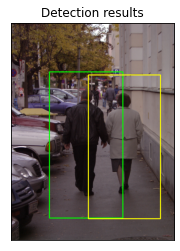

In [45]:
# initialize the HOG descriptor/person detector
hog = cv.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# load base image (check that we are not scaling, normalizing or changing the channels)
img = cv.imread(os.path.join('..','data', 'person_104.bmp'))
print('Image has dimensions: {}'.format(img.shape))

# The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
rects, weights = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.05)

# draw the original bounding boxes
persons = 0;
for (x, y, w, h) in rects:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, persons * 256), 2)
    persons += 1;
    
display_image(img);
plt.title('Detection results')
plt.xticks([])
plt.yticks([]);

#### 1.3.9.1 A not so trivial example

Image has dimensions: (480, 640, 3)


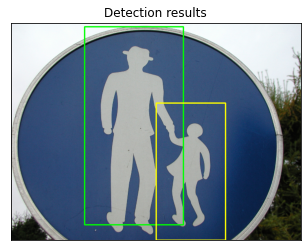

In [46]:
# load base image (check that we are not scaling, normalizing or changing the channels)
img = cv.imread(os.path.join('..','data', 'person_454.bmp'))
print('Image has dimensions: {}'.format(img.shape))

# The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
rects, weights = hog.detectMultiScale(img , winStride=(4, 4), padding=(8, 8), scale=1.05)

# draw the original bounding boxes
persons = 0;
for (x, y, w, h) in rects:
    cv2.rectangle(img , (x, y), (x + w, y + h), (0, 255, persons * 256), 2)
    persons += 1;
    
display_image(img);
plt.title('Detection results')
plt.xticks([])
plt.yticks([]);

### 1.3.10 References

https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

https://www.learnopencv.com/histogram-of-oriented-gradients/

http://juliaimages.github.io/ImageFeatures.jl/latest/tutorials/object_detection.html

https://www.learnopencv.com/tag/hog/

## 1.4 Introduction to Scale Invariant Feature Transform (*SIFT*)

(10 points)

### 1.4.1 Introduction

Good feature descriptor should be resilient to various geometric transformations such as *translsation*, *rotation* and *scaling*. For example, check a simple image below. A corner in a small image within a small window (*i.e. left side*) is flat when it is scaled up in the same window.

<img src="../data/corner.png" alt="Drawing" style="width: 350px;"/>

In 2004, **D.Lowe**, University of British Columbia, came up with a new feature descriptor, Scale Invariant Feature Transform (*SIFT*) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors ([ref](https://www.robots.ox.ac.uk/~vgg/research/affine/det_eval_files/lowe_ijcv2004.pdf)).

In order to achieve such invariance, there are four steps involved in *SIFT*:
- Detect extremums in Scale-space
- Localize keypoints
- Define Keypoint's orientation
- Build Keypoint descriptor

### 1.4.2 Detect extremums in Scale-space

From the example above, it is clear that we can not use one single window to detect keypoints with different scales. Therefore, ***scale-space*** filtering is used. In the filtering process, Laplacian of Gaussian (*LoG*) is computed for the image with various $\sigma$ values. The LoG act as a *blob* detector where $\sigma$ defines the "size" / "scale" of the blob to detect. With different values of $\sigma$ we can find **local** maxima across the scale and the position in the image which give a list of $\left(x, y, \sigma \right)$ values that are potential keypoint $\left( x, y\right)$ at scale $\sigma$.

The problem with this approach is that *LoG* is costly to compute. Therefore *SIFT* uses Differences of Gaussians (*DoG*) which is an approximation of *LoG*. *Dog* is computed as the difference between an image blurred with two different $\sigma$ value, one being $\sigma$ and the second one being $k \sigma$.  This process is done for different octaves of the image in a Gaussian Pyramid as shown in the image below:

<img src="../data/dog.png" alt="Drawing" style="width: 400px;"/>

Once *DoG* is computed, every layers are searched for local extrema over scale and space. An extrema is defined by comparing the pixel value with its 8 respective neighbours and the 9 neighbours from the previous and next scales as shown in the figure below:

<img src="../data/local_extrema.png" alt="Drawing" style="width: 250px;"/>

If it is a local extrema, potentially it is a keypoint. It means that keypoint is best represented in that scale. Regarding the parameters, the paper gives some empirical values; number of octaves = 4, number of scale levels = 5, initial $\sigma=1.6$, $k=\sqrt{2}$ as optimal values.

### 1.4.3 Localize keypoints

With potential keypoint locations, they need to be refined in order to increate the accuracy / robustness. Taylor expansion of the scale-space is used to have a better localization of the extrema and if its intensity is larger than a given treshold, the candidate is kept, otherwise it is discarded.

Edges in *Dog* pyramid will have large responses, therefore they need to be removed. To do so, the local curvature is computed using a 2x2 Hessian matrix. For edges, the ratio between the two eigenvalues of this matrix will be large, therefore if the ratio is larger than a given threshold, the candidate will be assumed to be an edge and be discarded.

After this step, low contrast position and edges will be discarded. Only the strong keypoints of interest remains.

### 1.4.4 Define orientation

So far keypoints have been treated to be rebust against scaling, now the rotation invariance need to be achieved. In a neigbourhood around the keypoint location with dimension depending on the scale, the gradient magnitude and direction is computed. An orientation histogram composed of 36 bins spanning $360^{\circ}$ is created, with each bin weighted by its gradient magnitude. The highest peak in the histogram is taken as keypoint's orientation. 


### 1.4.5 Build descriptor

Last step consists of building the keypoint's descriptor. To do so, a 16x16 neighbourhood is taken. The region is itself divided again into 16 sub-blocks of size 4x4. For each sub-blocks, an orientation histogram of 8 bins is computed. Finally, histogram from each sub-blocks are concatenated to form the final feature vector of dimension $8 \times 16 = 128$.

### 1.4.6 Your task

Given a list of [cv::keypoints](https://docs.opencv.org/3.2.0/d2/d29/classcv_1_1KeyPoint.html#a4484e94502486930e94e7391adf9d215) we ask you to implement below the function that will generate the visualization for each keypoints. We want to display the magnitude dans the orientation of each keypoints at their location $\left(x, y\right)$. The magnitude can be represented by a circle with its radius. The orientation on the other hand can be an axis going from the circle's center to the rim with proprer angle.

Check the documentation, for more information about how to draw [parts](https://docs.opencv.org/3.2.0/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2) with opencv ([circle](https://docs.opencv.org/3.2.0/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670), [line](https://docs.opencv.org/3.2.0/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2), ...).


In [47]:
def draw_keypoint(img, kps):
    """
    Draw SIFT keypoints on a given image. 
    
    :param img: Grayscale image from which SIFT features have been extracted
    :param kps: List of keypoints detected
    :return: Color image with magnitude and orientation of each detected keypoints 
             (Magnitude is shown as a circle and orientation has an axis going from the center of the circle towards 
             the rim with proper orientation)
    """
    # Convert Grayscale image to color BGR
    canvas = cv.cvtColor(img,cv.COLOR_GRAY2RGB)
    
    # Draw keypoints
    for i in range(0,len(kps)-1):
        
        # Calculation of parameters
        center = (int(kps[i].pt[0]), int(kps[i].pt[1]))
        R = int((kps[i].size)/2)
        orient = (math.cos(math.pi*kps[i].angle/180) , math.sin(math.pi*kps[i].angle/180))
        point =  (int(center[0] + R*orient[0]) , int(center[1] + R*orient[1])) 
                  
       
        # draw line and circle              
        cv.line(canvas, center, point,(0, 0, 255),2)
        cv.circle(canvas, center, R,(0,0,255),2)

    # Return canvas
    return canvas

Text(0.5, 1.0, 'SIFT Keypoints extracted')

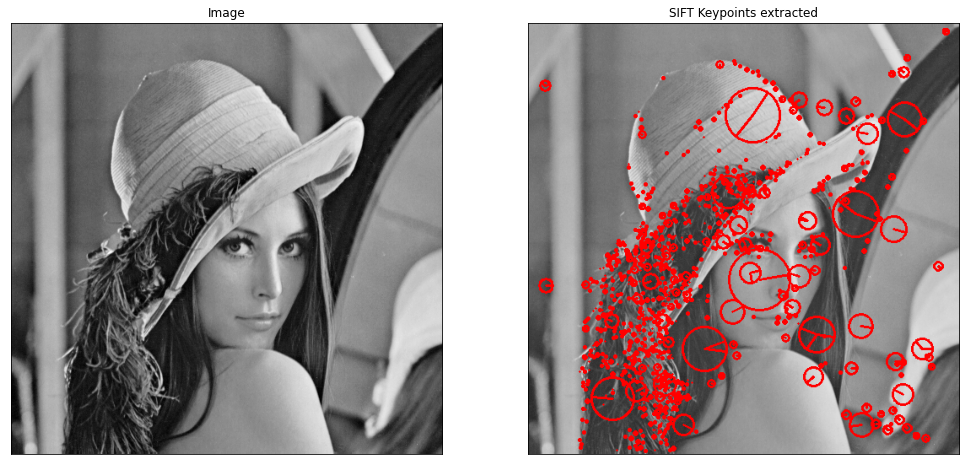

In [48]:
# Load image
img = cv.imread(os.path.join('..','data', 'lena.png'), cv.IMREAD_GRAYSCALE)
# Create sift extractor and detect keypoints
sift = cv.xfeatures2d.SIFT_create()
kps = sift.detect(img, None)

# Draw
canvas = draw_keypoint(img, kps)

# Display
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
display_image(img, axes=ax[0])
ax[0].set_title('Image')
display_image(canvas, axes=ax[1])
ax[1].set_title('SIFT Keypoints extracted')